# Exercises Week 11-12: Graded exercise session (part A)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2024-2025


In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import gammaln

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell before you submit.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. In addition to the simple birth-death process that we simulated in week 10, we will now consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } k\,n \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{array}

We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

*Hint*: In all of the exercises below, use rates that are possible biologically, especially for $s$ and $k$ (see course). Note that the units here are in minutes.

#### Question 1
1. Using the code template provided, which includes initial values and parameters, modify the Gillespie algorithm to simulate the Telegraph model. Focus on integrating the two-state model for the promoter accurately into the algorithm.

2. Explore several simulations where you vary the rates (e.g increase or decrease $k$, $s$, $k_{on}$, $k_{off}$), plot *three* representative examples with different rates and comment. Find cases that show qualitatively different behaviors. For each case, report the coefficient of variation of the number of mRNA copies ($CV=\frac{\sigma}{\mu}$). *Hint*: always show simulations of length at about 10-20 times $k^{-1}$.

#### Answers 1
1. We need to define the stoichiometric matrix `S` and the rate vector `rates` for each promoter state.
The matrix `S` defines the changes in the states *g* and *n* for each reaction:
    - **For g = 1:**

        $$
        S = 
        \begin{bmatrix}
        0 & 1 \\ 
        0 & -1 \\ 
        -1 & 0
        \end{bmatrix}
        $$

    - **For g = 0:**

        $$
        S = 
        \begin{bmatrix}
        1 & 0 \\
        0 & -1
        \end{bmatrix}
        $$

    The rate vector `rates` corresponds to the reaction rates:

    - **For g = 1:**

    $$
    \text{rates} = [s, k \cdot n, k_{\text{off}}]
    $$


    - **For g = 0:**

    $$
    \text{rates} = [k_{\text{on}}, k \cdot n]
    $$

2. Let's stimulate three different scenarios:
    - **Base case**: The promoter switches betweenc active and inactive states relatively infrequently. The mRNA count flucutates around the expected mean, with clear bursts when the promoter is active. Th CV is 2.048.
    - **Faster promoter switching**: The promoter switches more rapdily between active and inactive states. The mRNA count shows less extreme fluctuation, as the frequent swithcing averages out the effect of the two states. The CV is 0.544, which is lower than the base case, indicating less variability.
    - **Promoter almost always on**: The promoter switching rates are highly skewed towards the active state (high k_on, low k_off). The mRNA count fluctuates around a higher steady-state level with minimal influence from promoter switching. The CV is 0.204, which is likely very low, approaching that of a simple birth-death process. This scenario represents constitutive gene expression with low transcriptional noise, characteristic of housekeeping genes or highly expressed genes in certain cellular states.

#### Gillespie template

In [10]:
def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on, k_off = parameters 

    while t < t_end: 
        
        # Define the stoichiometric matrix S (also called state-change matrix) and rate vector for each promoter state
        if g == 1: # Promoter is active 
            S = np.array([[0, 1], # Transcription
                          [0, -1], # Degradation
                          [-1, 0]]) # Switching off
            rates = np.array([s, k * n, k_off])
        else: # Promoter is inactive
            S = np.array([[1, 0],   # Switch on
                          [0, -1]]) # Degradation
            rates = np.array([k_on, k * n])
        
        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        
        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

In [8]:
def plot_gillespie_telegraph(n, g, t):
    """
    Plots the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n: Species n counts over time.
    g: Promoter state g over time.
    t: Time points for each recorded reaction.

    """

    fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True)

    # Plotting the number of molecules n over time
    axs[0].plot(t, n, label = 'n(t)', color='darkblue')
    axs[0].set_ylabel('# molecules n')

    # Plotting the promoter activity over time
    axs[1].vlines(x=t, ymin=np.min(g), ymax=np.array(g), colors='teal', lw=2, label='promoter activity')
    axs[1].set_ylim(np.min(g), np.max(g)+0.1)  # Set y-limits to make the promoter states clear (0 and 1)
    axs[1].set_ylabel('Promoter State')
    
    # Common x-label
    plt.xlabel('time [min]')
    
    plt.show()

In [16]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate, 1/k = 50 min
k_off = 1/15 #Switching off rate, t_on = 1/k_off
k_on  = 1/120 #Switching on rate, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)
print(f"Pon:{p_on}") 

n_expected = s/k * p_on
# convert to integer
n_0 = int(n_expected)

t_end = 20 * 1/k # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

Pon:0.1111111111111111


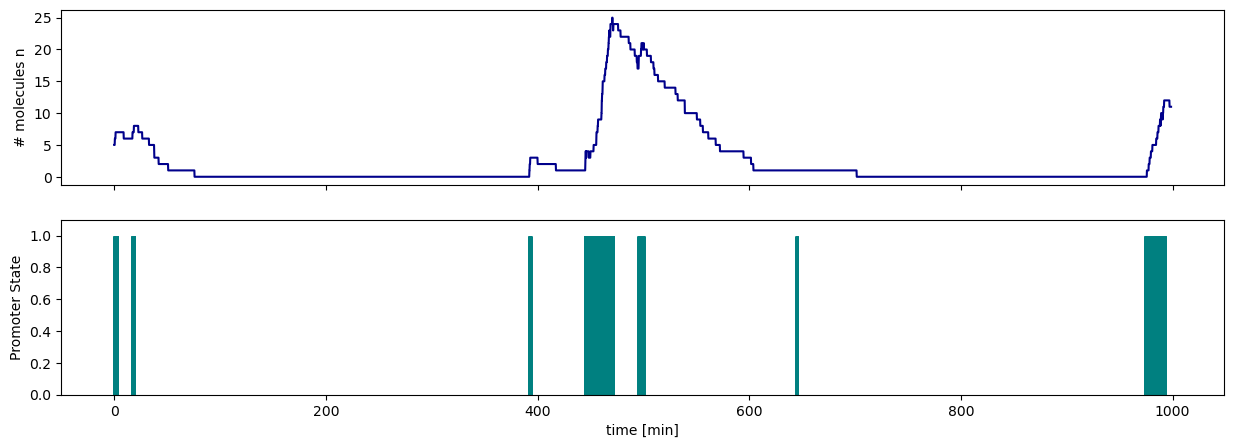

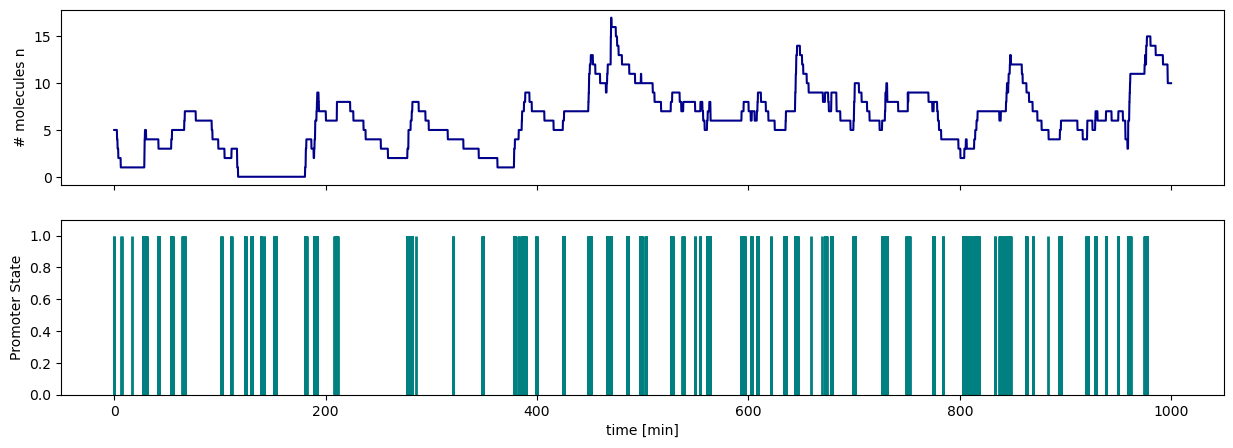

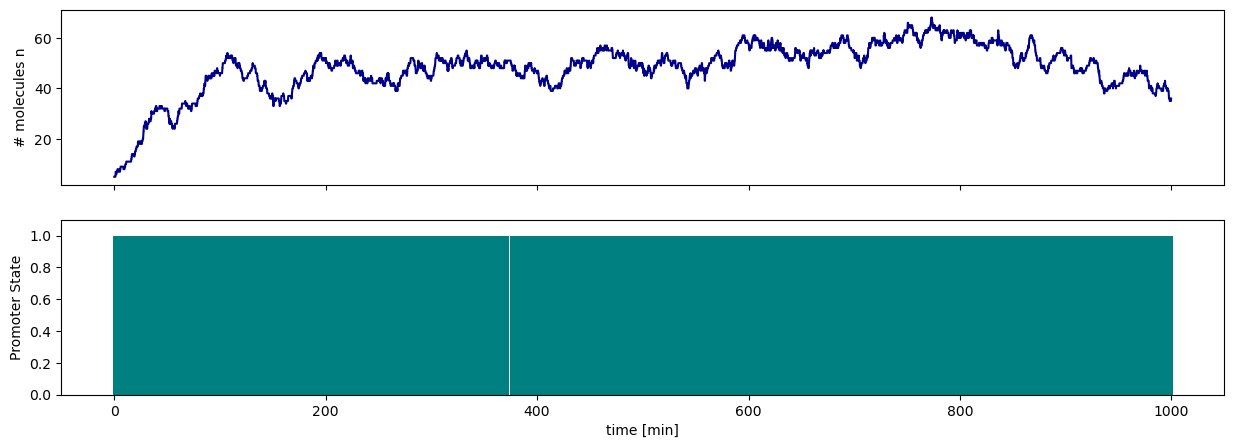

Base case CV: 2.048
Fast switching CV: 0.544
Slow degradation CV: 0.204


In [21]:
# 1. Define the initial conditions for the state (g,n) at time t=0
# Base case
base_parameters = [s, k, k_on, k_off]

# Faster promoter switching
fast_parameters = [s, k, k_on*10, k_off*10]

# Promoter almost always on
always_on_parameters = [s, k, k_on*100, k_off/100]


# 2. Run the Gillespie algorithm for the three different parameter sets
# Base case
n_base, g_base, t_base = run_gillespie_telegraph(n_0, g_0, base_parameters, t_end, DT)

# Faster promoter switching
n_fast, g_fast, t_fast = run_gillespie_telegraph(n_0, g_0, fast_parameters, t_end, DT)

# Almost always on promoter
n_always_on, g_always_on, t_always_on = run_gillespie_telegraph(n_0, g_0, always_on_parameters, t_end, DT)

# 3. Plot the results
# Plot base case
plot_gillespie_telegraph(n_base, g_base, t_base)

# Plot faster promoter switching
plot_gillespie_telegraph(n_fast, g_fast, t_fast)

# Plot always on promoter
plot_gillespie_telegraph(n_always_on, g_always_on, t_always_on)

# 4. Calculate the coefficient of variation (CV) for the number of molecules n
cv_base = np.std(n_base) / np.mean(n_base)
cv_fast = np.std(n_fast) / np.mean(n_fast)
cv_always_on = np.std(n_always_on) / np.mean(n_always_on)

print(f"Base case CV: {cv_base:.3f}")
print(f"Fast switching CV: {cv_fast:.3f}")
print(f"Slow degradation CV: {cv_always_on:.3f}")


#### Question 2
1. Study the distribution of mRNA numbers generated by your simulations. Identify parameters that results in a Poisson distribution of mRNA numbers. Show the empiral histogram and overlay an exact Poisson distribution. In this regime, explain how the parameters of the Telegraph model relate to the parameter of the Poisson distribution. *Hint*: $k_{off}=0$ with $g(t=0)=1$ is not the right answer. 

2. Find parameters where the mRNA distribution deviates from the Poisson. *Hint*: Look for a regime that yields a bimodal distribution. Explain your reasoning.

#### Answers 2
1. To achieve a Poisson-like distribution, we need to set parameters such that the promoter switches rapidly between states, effectively averaging out the two-state behavior. In this regime, the parameters of the Telegram model relate to the Poisson distribution as follows: The mean of the Poisson distribution ($λ$) is approximately equal to $s \cdot \frac {p_{on}}{k}$, where $p_{on} = \frac{k_{on}} {k_{on} + k_{off}}$. When $k_{on}$ and $k_{off}$ are large compared to $s$ and $k$, the promoter switches rapidly between states, and the overall behavior approaches that of a simple birth-death process with an effective transcription rate of s * p_on.
2. To achieve a bimodal distribution that deviates from Poisson, we can do as follow:
    - **Slow Switching Between States**:
    If the promoter switches states (active/inactive) slowly compared to the mRNA production and degradation dynamics, the system will spend extended periods in either the high mRNA production state or the low production state. This can create two distinct peaks in the mRNA distribution corresponding to the g=1g=1 and g=0g=0 states.
    - **Fast mRNA Dynamics**:  Ensure $k$ (mRNA degradation rate) is sufficiently large so that mRNA counts can equilibrate quickly when the promoter changes state. This ensures clear separation of the two peaks.
    - **Balanced Switching Rates**: Set $k_{on}$ and $k_{off}$ such that $p_{on} = \frac{k_{on}} {k_{on} + k_{off}}$ does not overwhelmingly favor one state over the other, allowing the system to occupy both states sufficiently often.
    
    This bimodal behavior deviates significantly from the Poisson distribution, which has only one peak. The deviation occurs because the assumptions of the simple birth-death process (constant probability of mRNA production) are violated when the promoter spends significant time in distinct ON and OFF states.

####  Helper functions for the Poisson distribution

In [22]:
# Poisson distribution
def Poisson(lam, counts):
    """
    Calculate the Poisson distribution probability for given counts.
    
    Parameters:
    lam: The average number of events (rate parameter).
    counts: Observed counts.

    Returns:
    np.array: Probabilities corresponding to the observed counts.

    Notes:
    - This function uses the log-form of the Poisson probability mass function.
    - The gammaln function is used for calculating the logarithm of the factorial term.

    """

    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

In [35]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state

##Find Parameters giving Poisson distribution
s = 10 # Number of initiations per minute 
k = 0.1 # Degradation rate, 1/k = 10 minutes
k_off = 5 #Switching off rate, t_on = 1/k_off = 0.2 minutes
k_on  = 5 #Switching on rate, t_off = 1/k_on =0.2

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)
n_expected = s/k * p_on
# convert to integer
n_0 = int(n_expected)

DT = 0.01 # min

print(f"Expected number of molecules: {n_0}")

t_end = 100 * 1/k # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]


Expected number of molecules: 50


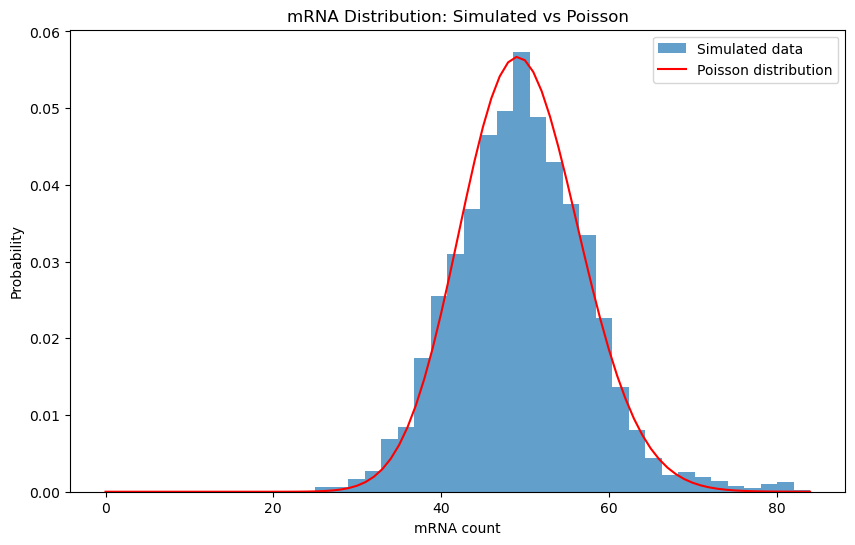

In [36]:
# Calculate mean for Poisson distribution
mean_mRNA = np.mean(n)

# Plot histogram and overlay Poisson distribution
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(n, bins=30, density=True, alpha=0.7, label='Simulated data')
x = np.arange(0, max(n)+1)
plt.plot(x, Poisson(mean_mRNA, x), 'r-', label='Poisson distribution')
plt.xlabel('mRNA count')
plt.ylabel('Probability')
plt.title('mRNA Distribution: Simulated vs Poisson')
plt.legend()
plt.show()

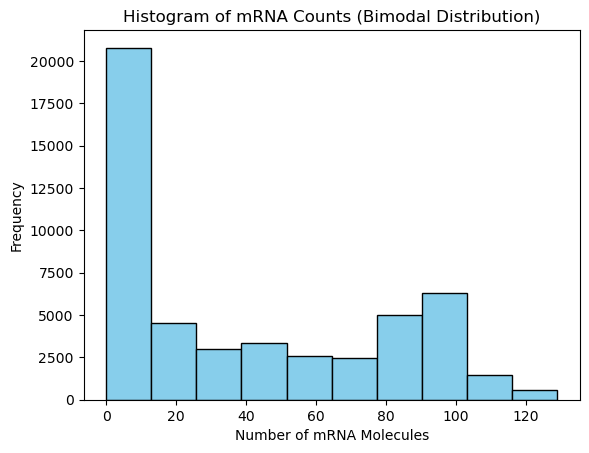

In [41]:
s = 20   # Number of initiations per minute
k = 0.2  # Degradation rate, 1/k = 10 minutes
k_off = 0.05  # Switching off rate, t_on = 1/k_off = 20 minutes
k_on = 0.05  # Switching on rate, t_off = 1/k_on = 20 minutes

parameters = [s, k, k_on, k_off]

n_traj, g_traj, t_traj = run_gillespie_telegraph(n_0, g_0, [s, k, k_on, k_off], t_end, DT)

# Plot histogram of mRNA counts
import matplotlib.pyplot as plt
import numpy as np

plt.hist(n_traj, color='skyblue', edgecolor='black')
plt.title('Histogram of mRNA Counts (Bimodal Distribution)')
plt.xlabel('Number of mRNA Molecules')
plt.ylabel('Frequency')
plt.show()


#### Question 3 (Promoter cycle)
Transcription in mammals often requires a more complicated telegraph model (promoter cycle), where the promoter state goes through an $ON$ state, and then sequentially goes through several $OFF_n$ state before returning to the ON state. For example with two $OFF$ states, it would look like: $ON\,(g=1)\longrightarrow OFF_1 (g=2) \longrightarrow OFF_2 (g=3) \longrightarrow ON (g=1)$. This is related to the fact that transcription events often show a refractory period, *i.e.* promoter tend to stay off for some amount of time before turning back on. 

1. Modify the above code to implement the promoter cycle with two $OFF$ state. First, use rates as in the example above with the following modifications: $s = 20$, $k = 0.02$, $k_{on-off_1} = 1/15$, $k_{off_1-off_2} = 1/60$ and $k_{off_2-on}  = 1/60$. Show some representative simulations. Plot both the mRNA and promoter state.

2. Study the distribution of the durations of each $OFF$ interval separately and of the two $OFF$ intervals together. Focus on the shape of the distributions. Explain your findings.

3. (Bonus). Can you explain mathematically the shape of the distribution? What would happen if you include more $OFF_n$ states?

#### Answers 3
1. See below
2. The distributions of OFF1 and OFF2 intervals are approximately exponential, which is expected for a single-step Markov process. The total OFF interval distribution, however, shows a peak away from zero, resembling a gamma distribution. This is because the total OFF time is the sum of two exponential random variables.
3. The shape of the individual OFF interval distributions (exponential) can be explained by the memoryless property of the Markov process. The probability of transitioning to the next state is constant and independent of how long the system has been in the current state. 

    The total OFF interval distribution resembles a gamma distribution because it's the sum of two independent exponential distributions.  In general, the sum of n independent exponential random variables with the same rate parameter follows a gamma distribution with shape parameter $n$. 

    If we include more OFF_n states, the total OFF interval distribution would still follow a gamma distribution, but with a larger shape parameter. This would result in a distribution that is more symmetric and has a peak further away from zero. As the number of OFF states increases, the distribution would approach a normal distribution due to the Central Limit Theorem

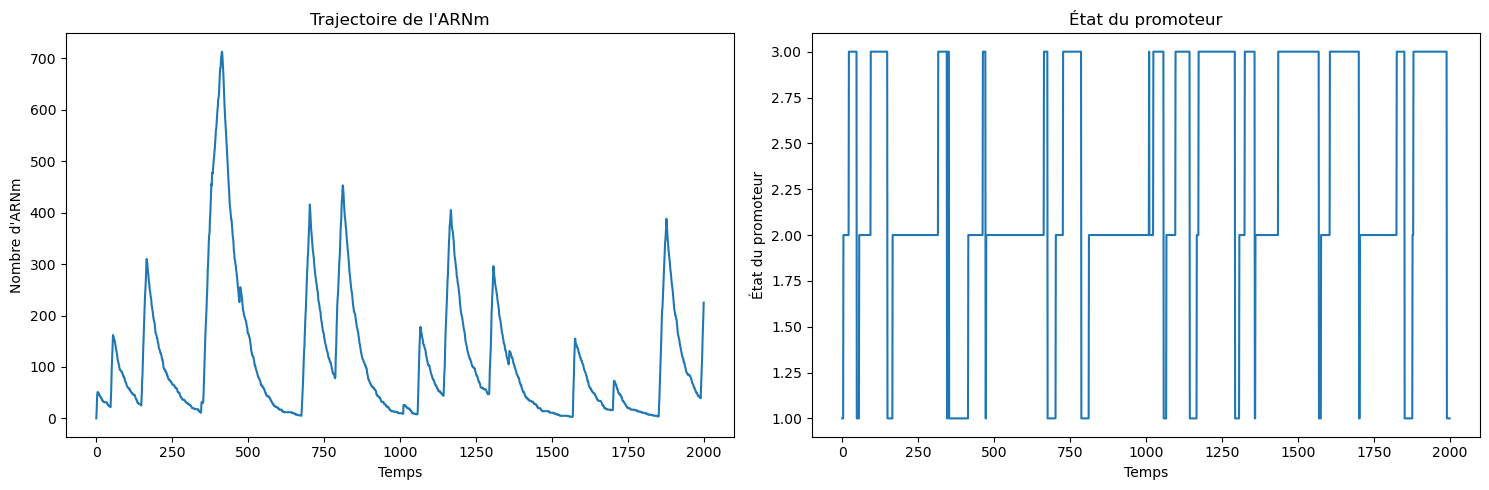

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telegraph process using the Gillespie algorithm with a promoter cycle.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0, 1, 2, or 3).
    parameters: Tuple containing transcription rate s, degradation rate k, and switching rates k_on-off1, k_off1-off2, k_off2-on
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on_off1, k_off1_off2, k_off2_on = parameters 

    while t < t_end: 
        
        # Define the stoichiometric matrix S (also called state-change matrix) and rate vector for each promoter state
        if g == 1: # Promoter is active 
            S = np.array([[0, 1], # Transcription
                          [0, -1], # Degradation
                          [1, 0]]) # Switching to OFF1
            rates = np.array([s, k * n, k_on_off1])
        elif g == 2: # Promoter is in OFF1 state
            S = np.array([[0, -1], # Degradation
                          [1, 0]]) # Switching to OFF2
            rates = np.array([k * n, k_off1_off2])
        elif g == 3: # Promoter is in OFF2 state
            S = np.array([[0, -1], # Degradation
                          [-2, 0]]) # Switching to ON
            rates = np.array([k * n, k_off2_on])
        else: # Promoter is in inactive state
            S = np.array([[0, -1], # Degradation
                          [1, 0]]) # Switching to ON
            rates = np.array([k * n, k_on_off1])
        
        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        
        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

# Paramètres pour la simulation
parameters = (20, 0.02, 1/15, 1/60, 1/60)
n0 = 0
g0 = 1
t_end = 2000
DT = 1

# Effectuer la simulation
n_print, g_print, t_print = run_gillespie_telegraph(n0, g0, parameters, t_end, DT)

# Tracer les résultats
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(t_print, n_print)
plt.xlabel('Temps')
plt.ylabel('Nombre d\'ARNm')
plt.title('Trajectoire de l\'ARNm')

plt.subplot(1, 2, 2)
plt.plot(t_print, g_print)
plt.xlabel('Temps')
plt.ylabel('État du promoteur')
plt.title('État du promoteur')

plt.tight_layout()
plt.show()

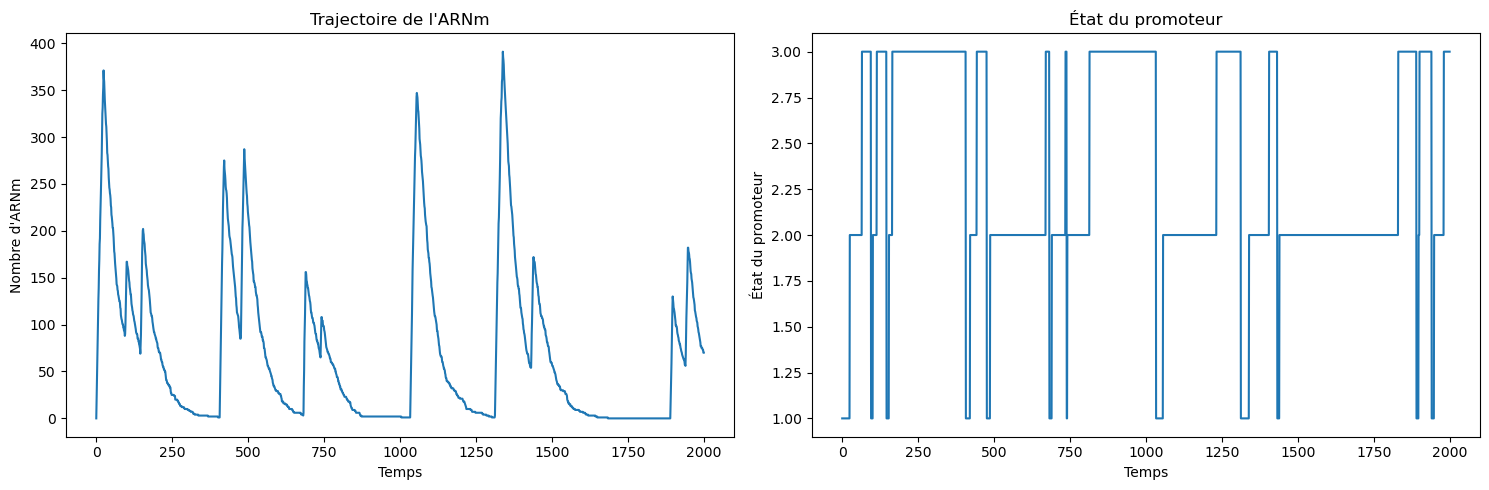

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telegraph process using the Gillespie algorithm with a promoter cycle.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (1, 2, or 3).
    parameters: Tuple containing transcription rate s, degradation rate k, and switching rates k_on-off1, k_off1-off2, k_off2-on
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on_off1, k_off1_off2, k_off2_on = parameters 

    while t < t_end: 
        
        # Define the stoichiometric matrix S (also called state-change matrix) and rate vector for each promoter state
        if g == 1: # Promoter is active 
            S = np.array([[0, 1], # Transcription
                          [0, -1], # Degradation
                          [1, 0]]) # Switching to OFF1
            rates = np.array([s, k * n, k_on_off1])
        elif g == 2: # Promoter is in OFF1 state
            S = np.array([[0, -1], # Degradation
                          [1, 0]]) # Switching to OFF2
            rates = np.array([k * n, k_off1_off2])
        elif g == 3: # Promoter is in OFF2 state
            S = np.array([[0, -1], # Degradation
                          [-2, 0]]) # Switching to ON
            rates = np.array([k * n, k_off2_on])
        
        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        
        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

# Paramètres pour la simulation
parameters = (20, 0.02, 1/15, 1/60, 1/60)
n0 = 0
g0 = 1
t_end = 2000
DT = 1

# Effectuer la simulation
n_print, g_print, t_print = run_gillespie_telegraph(n0, g0, parameters, t_end, DT)

# Tracer les résultats
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(t_print, n_print)
plt.xlabel('Temps')
plt.ylabel('Nombre d\'ARNm')
plt.title('Trajectoire de l\'ARNm')

plt.subplot(1, 2, 2)
plt.plot(t_print, g_print)
plt.xlabel('Temps')
plt.ylabel('État du promoteur')
plt.title('État du promoteur')

plt.tight_layout()
plt.show()